Loading data from daily_regression_data.csv...


/var/folders/l3/m0hmzwtx6x78f3q7cv6fpfl00000gn/T/ipykernel_95328/2158604681.py:18: FutureWarning: YF.download() has changed argument auto_adjust default to True
  treasury_data = yf.download('^IRX', start=start_date, end=end_date, progress=False)



Plot saved as '../results/sharpe_comparison.png'

SHARPE RATIO & CENTRALITY ANALYSIS SUMMARY

Data Period: 2021-04-12 to 2025-07-22
Number of observations: 1563

ETH Sharpe Ratio:
  Mean:     0.408
  Median:  -0.003
  Std:      2.990

S&P 500 Sharpe Ratio:
  Mean:     0.371
  Median:  -0.112
  Std:      3.148

Centrality (top20_mean):
  Mean:            4.642
  High threshold (75th):   4.785
  Low threshold (25th):    4.509
  High centrality days: 391 (25.0%)
  Low centrality days:  391 (25.0%)

Sharpe Ratios by Centrality Period:
  ETH - High Centrality:     1.152
  ETH - Low Centrality:      0.819
  S&P - High Centrality:     1.475
  S&P - Low Centrality:      0.787

Relative Performance:
  Days ETH outperforms S&P 500:   829 (53.0%)
  Days S&P 500 outperforms ETH:   705 (45.1%)
  Mean Sharpe difference (ETH-S&P): 0.037

KEY INSIGHTS
• ETH Sharpe ratio is higher on average than S&P 500
• High centralization occurs in 25.0% of days (top20_mean > 4.78)
• During high centrality: ETH Sh

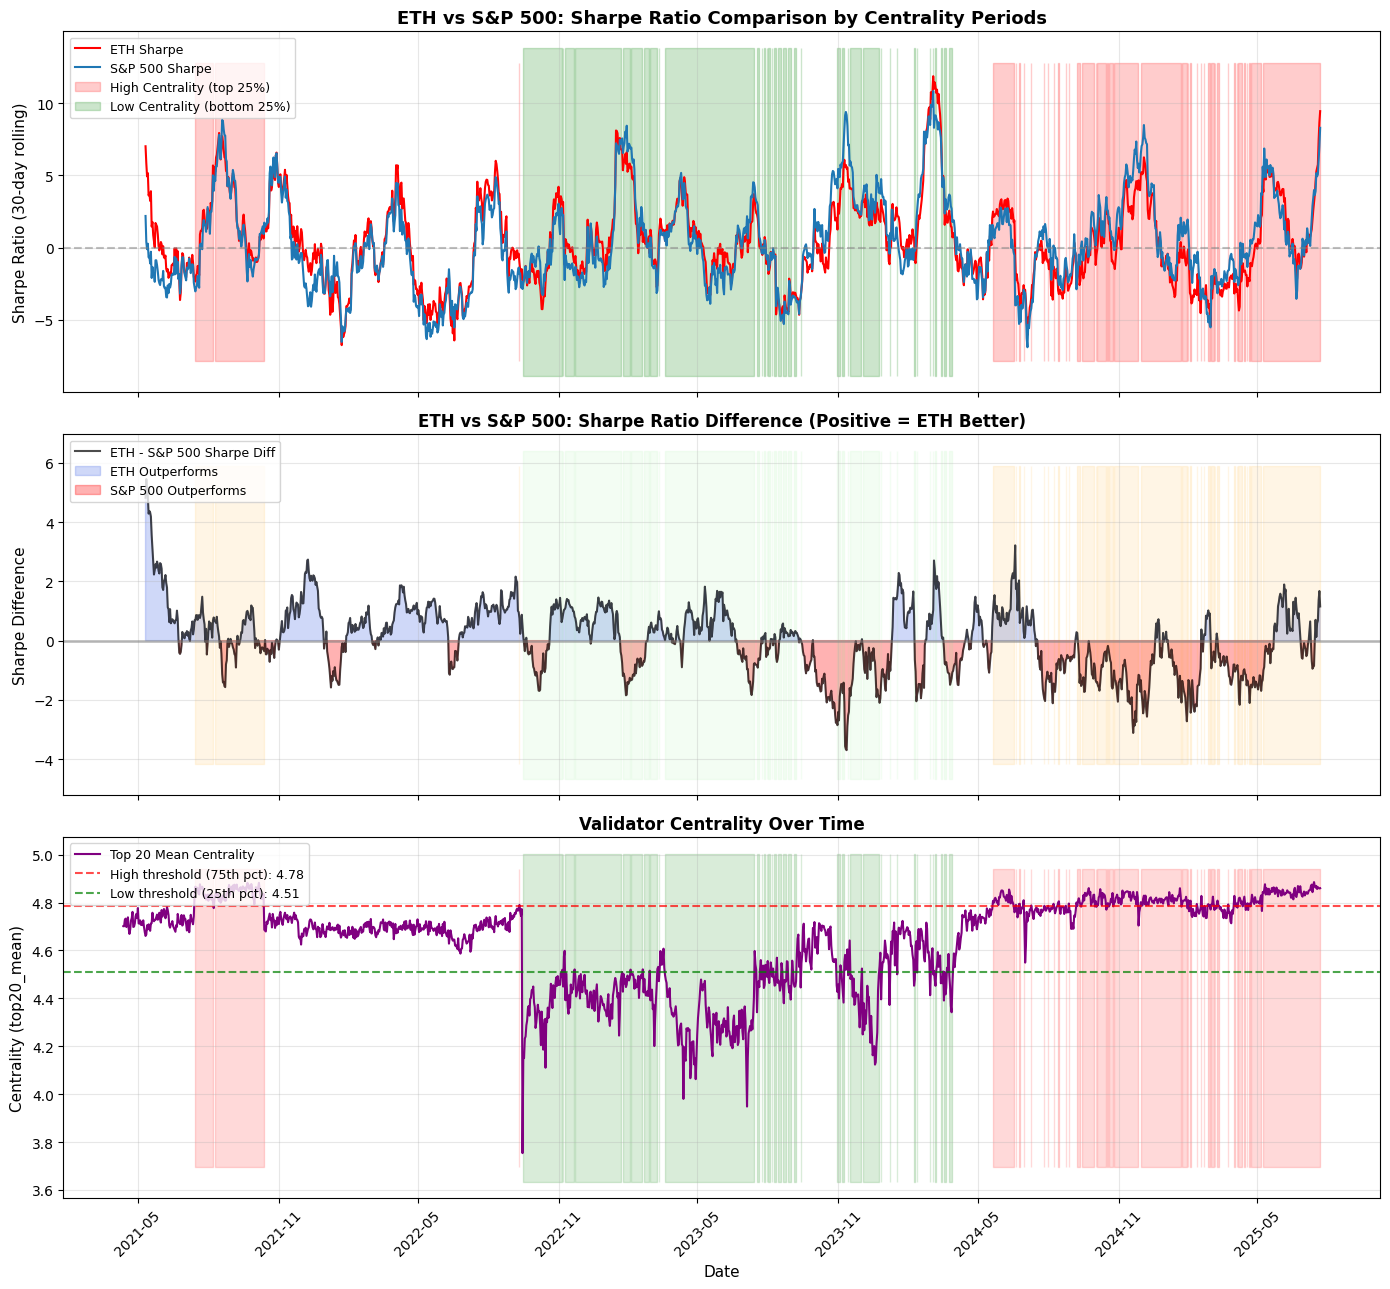

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Load existing data
print("Loading data from daily_regression_data.csv...")
df = pd.read_csv('../data/processed/daily_regression_data.csv')
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Download risk-free rate (Treasury Bill) to match 2SLS approach
print("Downloading Treasury Bill rate data...")
start_date = df.index.min()
end_date = df.index.max()
treasury_data = yf.download('^IRX', start=start_date, end=end_date, progress=False)
treasury_data = treasury_data[['Close']].copy()
treasury_data.columns = ['interest_rate']
treasury_data.index.name = 'date'
treasury_data = treasury_data.reset_index()
treasury_data['daily_rf'] = (treasury_data['interest_rate'] / 100) / 252

# Merge with main dataset
df = df.reset_index()
df = df.merge(treasury_data[['date', 'daily_rf']], on='date', how='left')
df['daily_rf'] = df['daily_rf'].ffill()
df = df.set_index('date')

# Rename columns to match (eth_return and market_return already in data)
df = df.rename(columns={'eth_return': 'eth_returns', 'market_return': 'sp500_returns'})
df = df.dropna(subset=['eth_returns', 'sp500_returns', 'daily_rf'])

# Calculate rolling Sharpe ratios (30-day window)
window = 30
df['eth_excess'] = df['eth_returns'] - df['daily_rf']
df['sp500_excess'] = df['sp500_returns'] - df['daily_rf']

df['eth_sharpe'] = (df['eth_excess'].rolling(window).mean() * 252) / \
                   (df['eth_returns'].rolling(window).std() * np.sqrt(252))
df['sp500_sharpe'] = (df['sp500_excess'].rolling(window).mean() * 252) / \
                     (df['sp500_returns'].rolling(window).std() * np.sqrt(252))

# Calculate rolling volatility (annualized)
df['eth_vol'] = df['eth_returns'].rolling(window).std() * np.sqrt(252)
df['sp500_vol'] = df['sp500_returns'].rolling(window).std() * np.sqrt(252)

# Identify high and low centrality periods using top20_mean
centrality_high_threshold = df['top20_mean'].quantile(0.75)
centrality_low_threshold = df['top20_mean'].quantile(0.25)

df['high_centrality'] = df['top20_mean'] > centrality_high_threshold
df['low_centrality'] = df['top20_mean'] < centrality_low_threshold

# Calculate Sharpe ratio difference
df['sharpe_diff'] = df['eth_sharpe'] - df['sp500_sharpe']

# Create visualization
fig, axes = plt.subplots(3, 1, figsize=(14, 13), sharex=True)

# Sharpe Ratio Plot
ax1 = axes[0]
ax1.plot(df.index, df['eth_sharpe'], label='ETH Sharpe', color='red', linewidth=1.5)
ax1.plot(df.index, df['sp500_sharpe'], label='S&P 500 Sharpe', color='#1f77b4', linewidth=1.5)
ax1.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
ax1.fill_between(df.index, ax1.get_ylim()[0], ax1.get_ylim()[1], where=df['high_centrality'], 
                  alpha=0.2, color='red', label='High Centrality (top 25%)')
ax1.fill_between(df.index, ax1.get_ylim()[0], ax1.get_ylim()[1], where=df['low_centrality'],
                  alpha=0.2, color='green', label='Low Centrality (bottom 25%)')
ax1.set_ylabel('Sharpe Ratio (30-day rolling)', fontsize=11)
ax1.set_title('ETH vs S&P 500: Sharpe Ratio Comparison by Centrality Periods', 
              fontsize=13, fontweight='bold')
ax1.legend(loc='upper left', fontsize=9)
ax1.grid(True, alpha=0.3)

# Sharpe Difference Plot (ETH - S&P 500)
ax2 = axes[1]
ax2.plot(df.index, df['sharpe_diff'], label='ETH - S&P 500 Sharpe Diff', color='black', linewidth=1.5, alpha=0.7)
ax2.axhline(y=0, color='gray', linestyle='-', linewidth=2, alpha=0.5)
ax2.fill_between(df.index, df['sharpe_diff'], 0, where=(df['sharpe_diff'] > 0), 
                  alpha=0.3, color='#627EEA', label='ETH Outperforms', interpolate=True)
ax2.fill_between(df.index, df['sharpe_diff'], 0, where=(df['sharpe_diff'] <= 0),
                  alpha=0.3, color='red', label='S&P 500 Outperforms', interpolate=True)
ax2.fill_between(df.index, ax2.get_ylim()[0], ax2.get_ylim()[1], where=df['high_centrality'], 
                  alpha=0.1, color='orange')
ax2.fill_between(df.index, ax2.get_ylim()[0], ax2.get_ylim()[1], where=df['low_centrality'],
                  alpha=0.1, color='lightgreen')
ax2.set_ylabel('Sharpe Difference', fontsize=11)
ax2.set_title('ETH vs S&P 500: Sharpe Ratio Difference (Positive = ETH Better)', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=9)
ax2.grid(True, alpha=0.3)

# Centrality Plot
ax3 = axes[2]
ax3.plot(df.index, df['top20_mean'], label='Top 20 Mean Centrality', color='purple', linewidth=1.5)
ax3.axhline(y=centrality_high_threshold, color='red', linestyle='--', alpha=0.7, 
            label=f'High threshold (75th pct): {centrality_high_threshold:.2f}')
ax3.axhline(y=centrality_low_threshold, color='green', linestyle='--', alpha=0.7,
            label=f'Low threshold (25th pct): {centrality_low_threshold:.2f}')
ax3.fill_between(df.index, ax3.get_ylim()[0], ax3.get_ylim()[1], where=df['high_centrality'], 
                  alpha=0.15, color='red')
ax3.fill_between(df.index, ax3.get_ylim()[0], ax3.get_ylim()[1], where=df['low_centrality'],
                  alpha=0.15, color='green')
ax3.set_ylabel('Centrality (top20_mean)', fontsize=11)
ax3.set_xlabel('Date', fontsize=11)
ax3.set_title('Validator Centrality Over Time', fontsize=12, fontweight='bold')
ax3.legend(loc='upper left', fontsize=9)
ax3.grid(True, alpha=0.3)

# Format x-axis
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax3.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('../results/sharpe_comparison.png', dpi=300, bbox_inches='tight')
print("\nPlot saved as '../results/sharpe_comparison.png'")

# Summary statistics
print("\n" + "="*80)
print("SHARPE RATIO & CENTRALITY ANALYSIS SUMMARY")
print("="*80)
print(f"\nData Period: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Number of observations: {len(df)}")

print(f"\nETH Sharpe Ratio:")
print(f"  Mean:   {df['eth_sharpe'].mean():>7.3f}")
print(f"  Median: {df['eth_sharpe'].median():>7.3f}")
print(f"  Std:    {df['eth_sharpe'].std():>7.3f}")

print(f"\nS&P 500 Sharpe Ratio:")
print(f"  Mean:   {df['sp500_sharpe'].mean():>7.3f}")
print(f"  Median: {df['sp500_sharpe'].median():>7.3f}")
print(f"  Std:    {df['sp500_sharpe'].std():>7.3f}")

print(f"\nCentrality (top20_mean):")
print(f"  Mean:          {df['top20_mean'].mean():>7.3f}")
print(f"  High threshold (75th): {centrality_high_threshold:>7.3f}")
print(f"  Low threshold (25th):  {centrality_low_threshold:>7.3f}")
print(f"  High centrality days: {df['high_centrality'].sum()} ({df['high_centrality'].sum()/len(df)*100:.1f}%)")
print(f"  Low centrality days:  {df['low_centrality'].sum()} ({df['low_centrality'].sum()/len(df)*100:.1f}%)")

# Sharpe ratios during different centrality periods
high_cent_eth_sharpe = df[df['high_centrality']]['eth_sharpe'].mean()
low_cent_eth_sharpe = df[df['low_centrality']]['eth_sharpe'].mean()
high_cent_sp500_sharpe = df[df['high_centrality']]['sp500_sharpe'].mean()
low_cent_sp500_sharpe = df[df['low_centrality']]['sp500_sharpe'].mean()

print(f"\nSharpe Ratios by Centrality Period:")
print(f"  ETH - High Centrality:   {high_cent_eth_sharpe:>7.3f}")
print(f"  ETH - Low Centrality:    {low_cent_eth_sharpe:>7.3f}")
print(f"  S&P - High Centrality:   {high_cent_sp500_sharpe:>7.3f}")
print(f"  S&P - Low Centrality:    {low_cent_sp500_sharpe:>7.3f}")

# Performance comparison
eth_outperforms = (df['sharpe_diff'] > 0).sum()
sp500_outperforms = (df['sharpe_diff'] <= 0).sum()
print(f"\nRelative Performance:")
print(f"  Days ETH outperforms S&P 500:   {eth_outperforms} ({eth_outperforms/len(df)*100:.1f}%)")
print(f"  Days S&P 500 outperforms ETH:   {sp500_outperforms} ({sp500_outperforms/len(df)*100:.1f}%)")
print(f"  Mean Sharpe difference (ETH-S&P): {df['sharpe_diff'].mean():.3f}")

# Key insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"• ETH Sharpe ratio is {'higher' if df['eth_sharpe'].mean() > df['sp500_sharpe'].mean() else 'lower'} on average than S&P 500")
print(f"• High centralization occurs in {df['high_centrality'].sum()/len(df)*100:.1f}% of days (top20_mean > {centrality_high_threshold:.2f})")
print(f"• During high centrality: ETH Sharpe={high_cent_eth_sharpe:.2f}, S&P Sharpe={high_cent_sp500_sharpe:.2f}")
print(f"• During low centrality: ETH Sharpe={low_cent_eth_sharpe:.2f}, S&P Sharpe={low_cent_sp500_sharpe:.2f}")
